# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import math
import copy
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.fk_module import GraceLitModule
from src.models.components.fk_net import FKNet
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import mse_loss

# Helper Functions

In [2]:
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

def min_max_scaler(arr, min_val, max_val):
    scaled_arr = 2 * (arr - min_val) / (max_val - min_val) - 1
    return scaled_arr

def preprocess_csv(data_dir, val_size=0.3, seed=75):
    # Read CSV
    df = pd.read_csv(data_dir)

    # Add Cmd of Current Time Step
    df['cmd_lnt_t'] = np.array(len(df)*[-13])
    df['cmd_lnp_t'] = np.array(len(df)*[-40])
    df['cmd_unt_t'] = np.array(len(df)*[44])
    df['cmd_lep_t'] = np.array(len(df)*[-18])
    df['cmd_rep_t'] = np.array(len(df)*[-18])
    df['cmd_et_t'] = np.array(len(df)*[22])

    # Reorganizing DataFrame
    data_df = pd.DataFrame({
        # Input
        'cmd_lnt_tplus1': df['cmd_theta_lower_neck_tilt'].values,
        'cmd_lnp_tplus1': df['cmd_theta_lower_neck_pan'].values,
        'cmd_unt_tplus1': df['cmd_theta_upper_neck_tilt'].values,
        'cmd_et_tplus1': df['cmd_theta_eyes_tilt'].values,
        'cmd_lep_tplus1': df['cmd_theta_left_eye_pan'].values,
        'cmd_rep_tplus1': df['cmd_theta_right_eye_pan'].values,

        # Add Cmd of Current Time Step
        'cmd_lnt_t': np.array(len(df)*[-13]),
        'cmd_lnp_t': np.array(len(df)*[-40]),
        'cmd_unt_t': np.array(len(df)*[44]),
        'cmd_et_t': np.array(len(df)*[22]),
        'cmd_lep_t': np.array(len(df)*[-18]),
        'cmd_rep_t': np.array(len(df)*[-18]),

        # Targets
        'l_rvec_0': df['l_rvec_0'].values,
        'l_rvec_1': df['l_rvec_1'].values,
        'l_rvec_2': df['l_rvec_2'].values,
        'l_tvec_0': df['l_tvec_0'].values,
        'l_tvec_1': df['l_tvec_1'].values,
        'l_tvec_2': df['l_tvec_2'].values,
        'r_rvec_0': df['r_rvec_0'].values,
        'r_rvec_1': df['r_rvec_1'].values,
        'r_rvec_2': df['r_rvec_2'].values,
        'r_tvec_0': df['r_tvec_0'].values,
        'r_tvec_1': df['r_tvec_1'].values,
        'r_tvec_2': df['r_tvec_2'].values,
    })

    # Minmax Feature Scaler
    feature_ranges = {
        'cmd_lnt_tplus1': (-44, 44),
        'cmd_lnp_tplus1': (-44, 44),
        'cmd_unt_tplus1': (-44, 44),
        'cmd_et_tplus1': (-44, 44),
        'cmd_lep_tplus1': (-44, 44),
        'cmd_rep_tplus1': (-44, 44),
        'cmd_lnt_t': (-44, 44),
        'cmd_lnp_t': (-44, 44),
        'cmd_unt_t': (-44, 44),
        'cmd_et_t': (-44, 44),
        'cmd_lep_t': (-44, 44),
        'cmd_rep_t': (-44, 44),
        'l_rvec_0': (-1.5708, 1.5708),
        'l_rvec_1': (-1.5708, 1.5708),
        'l_rvec_2': (-1.5708, 1.5708),
        'l_tvec_0': (-1.5, 1.5),  
        'l_tvec_1': (-1.5, 1.5),  
        'l_tvec_2': (-1.5, 1.5),
        'r_rvec_0': (-1.5708, 1.5708),
        'r_rvec_1': (-1.5708, 1.5708),
        'r_rvec_2': (-1.5708, 1.5708),
        'r_tvec_0': (-1.5, 1.5),
        'r_tvec_1': (-1.5, 1.5),  
        'r_tvec_2': (-1.5, 1.5),
    }
    
    # All Dataset
    all_df = data_df.copy()

    # Separation of Training and Validation Set
    train_df, temp_df = train_test_split(data_df, test_size=val_size, random_state=seed)
    val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=seed)

    # Training Set
    X_train = torch.tensor(train_df.iloc[:,:12].values, dtype=torch.float32)
    y_train = torch.tensor(train_df.iloc[:,12:].values, dtype=torch.float32)
    train_dataset = TensorDataset(X_train, y_train)

    # Validation Set
    X_val = torch.tensor(val_df.iloc[:,:12].values, dtype=torch.float32)
    y_val = torch.tensor(val_df.iloc[:,12:].values, dtype=torch.float32)
    val_dataset = TensorDataset(X_val, y_val)

    # Test Set
    X_test = torch.tensor(test_df.iloc[:,:12].values, dtype=torch.float32)
    y_test = torch.tensor(test_df.iloc[:,12:].values, dtype=torch.float32)
    test_dataset = TensorDataset(X_test, y_test)
    
    # Scaled All Set
    scaled_all_df = all_df.copy()
    for col in all_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_all_df[col] = 2 * (all_df[col] - col_min) / (col_max - col_min) - 1
    
    # Scaled Train Set
    scaled_train_df = train_df.copy()
    for col in train_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_train_df[col] = 2 * (train_df[col] - col_min) / (col_max - col_min) - 1
        
    # Scaled Val Set
    scaled_val_df = val_df.copy()
    for col in val_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_val_df[col] = 2 * (val_df[col] - col_min) / (col_max - col_min) - 1
    
    # Scaled Test Set
    scaled_test_df = test_df.copy()
    for col in test_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_test_df[col] = 2 * (test_df[col] - col_min) / (col_max - col_min) - 1

    return all_df, train_df, val_df, test_df, scaled_all_df, scaled_train_df, scaled_val_df, scaled_test_df


# Error Histogram

In [3]:
csv_fn = '/home/jaynieles/dev/grace_dl/logs/fk/runs/2024-10-24_22-01-55/tensorboard/version_0/delta_output_analysis.csv'
csv_df = pd.read_csv(csv_fn)

## Left Camera

Text(0.5, 1.0, 'Left Rvec 0')

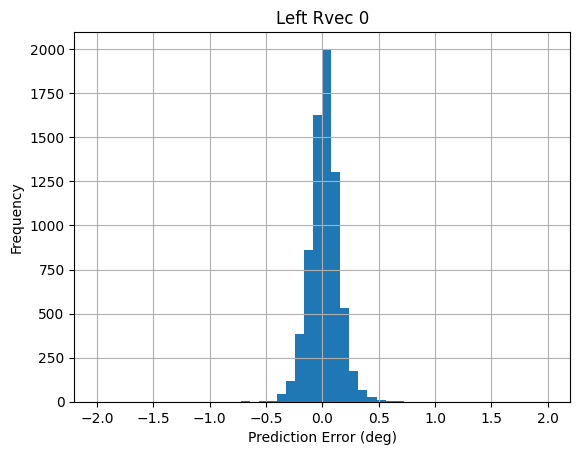

In [4]:
plt.hist(np.degrees(csv_df['delta_l_rvec_0']), bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 0')

Text(0.5, 1.0, 'Left Rvec 1')

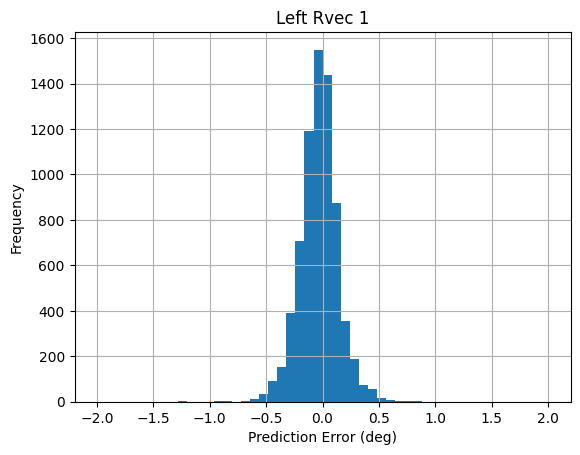

In [5]:
plt.hist(np.degrees(csv_df['delta_l_rvec_1']), bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 1')

Text(0.5, 1.0, 'Left Rvec 2')

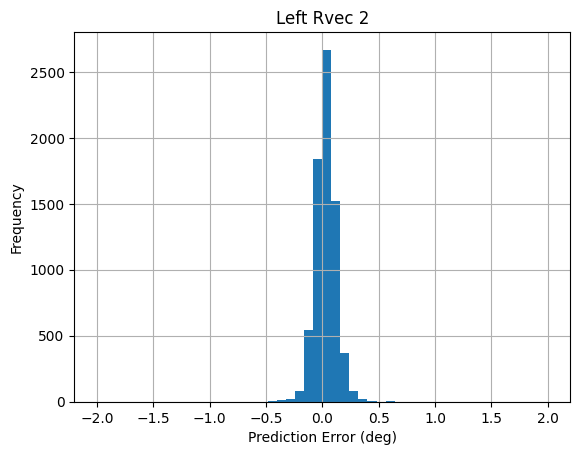

In [6]:
plt.hist(np.degrees(csv_df['delta_l_rvec_2']), bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 2')

Text(0.5, 1.0, 'Left Tvec 0')

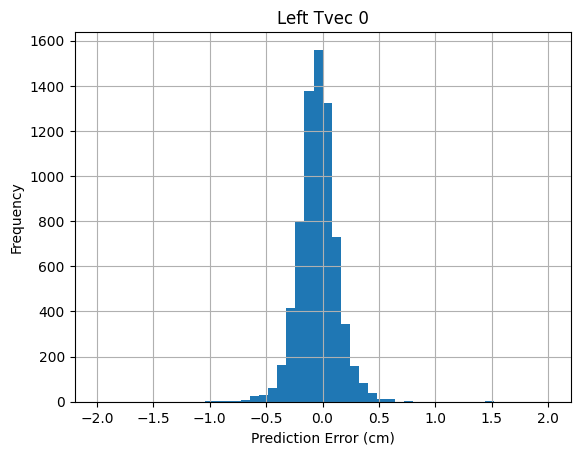

In [7]:
plt.hist(100*csv_df['delta_l_tvec_0'], bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Left Tvec 0')

Text(0.5, 1.0, 'Left Tvec 1')

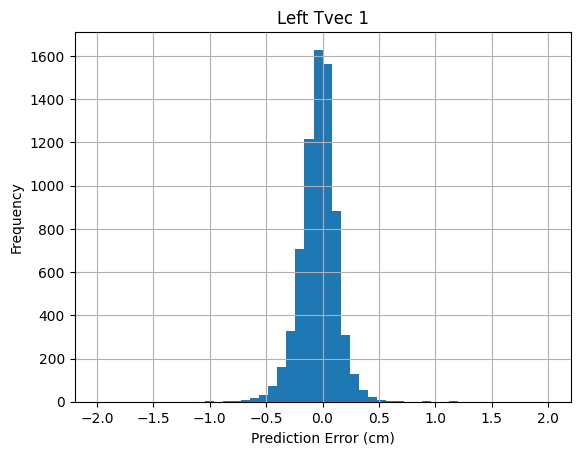

In [8]:
plt.hist(100*csv_df['delta_l_tvec_1'], bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Left Tvec 1')

Text(0.5, 1.0, 'Left Tvec 2')

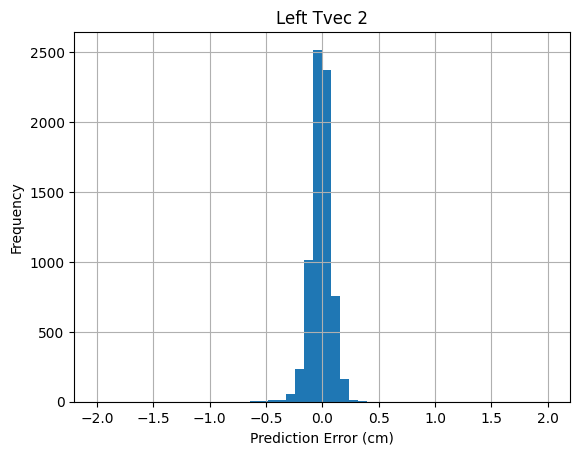

In [9]:
plt.hist(100*csv_df['delta_l_tvec_2'], bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Left Tvec 2')

## Right Camera

Text(0.5, 1.0, 'Right Rvec 0')

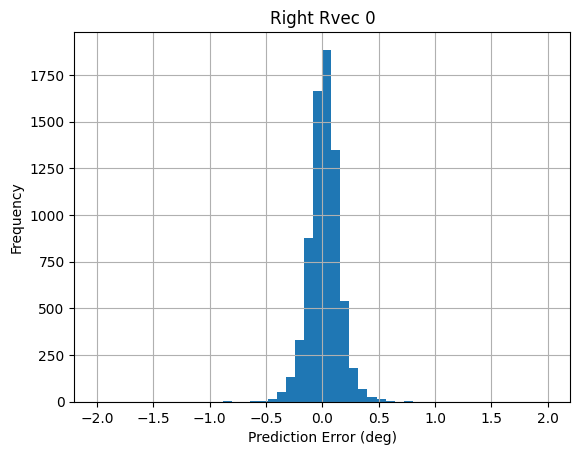

In [10]:
plt.hist(np.degrees(csv_df['delta_r_rvec_0']), bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 0')

Text(0.5, 1.0, 'Right Rvec 1')

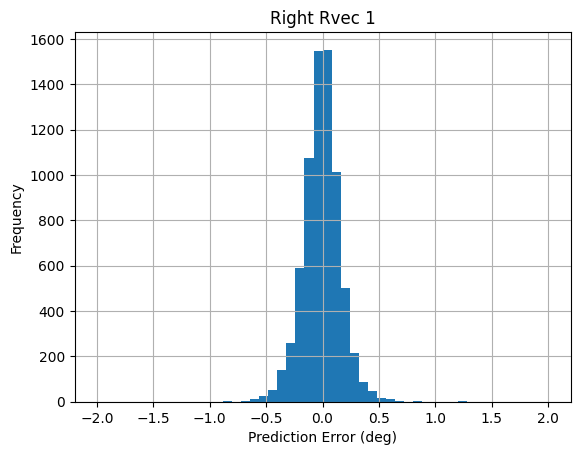

In [11]:
plt.hist(np.degrees(csv_df['delta_r_rvec_1']), bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 1')

Text(0.5, 1.0, 'Right Rvec 2')

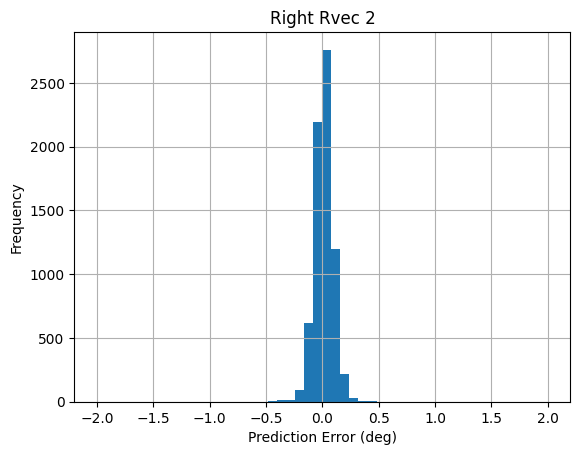

In [12]:
plt.hist(np.degrees(csv_df['delta_r_rvec_2']), bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 2')

Text(0.5, 1.0, 'Right Tvec 0')

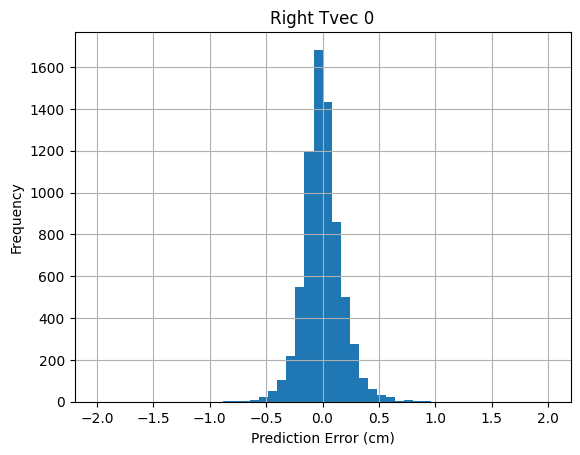

In [13]:
plt.hist(100*csv_df['delta_r_tvec_0'], bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Right Tvec 0')

Text(0.5, 1.0, 'Right Tvec 1')

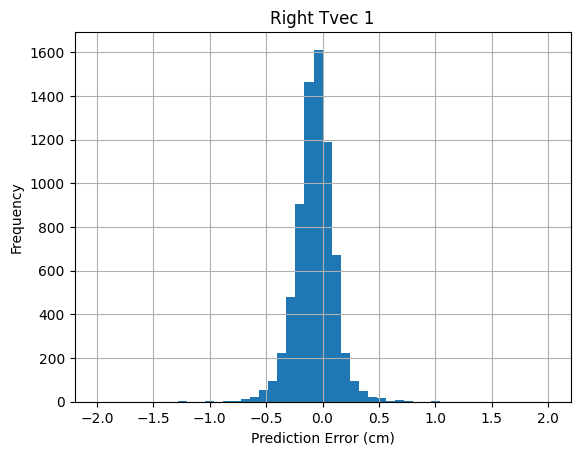

In [14]:
plt.hist(100*csv_df['delta_r_tvec_1'], bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Right Tvec 1')

Text(0.5, 1.0, 'Right Tvec 2')

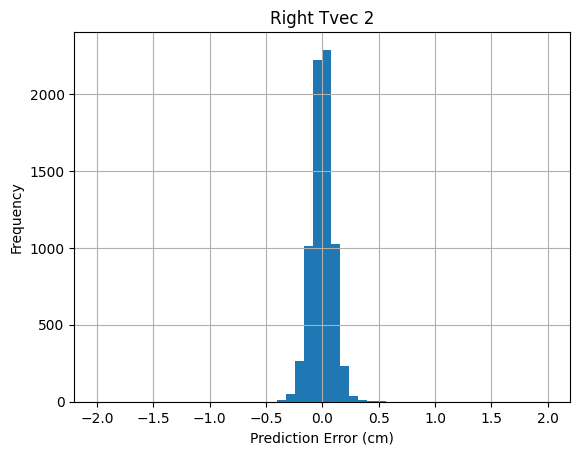

In [15]:
plt.hist(100*csv_df['delta_r_tvec_2'], bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Right Tvec 2')

# Error Table

In [16]:
results_idx = ['r(deg)','p(deg)', 'y(deg)', 'x(cm)','y(cm)', 'z(cm)',]
results_df = pd.DataFrame({'Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_0'].values),torch.Tensor(100*csv_df['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_1'].values),torch.Tensor(100*csv_df['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_2'].values),torch.Tensor(100*csv_df['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_0'].values),torch.Tensor(100*csv_df['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_1'].values),torch.Tensor(100*csv_df['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_2'].values),torch.Tensor(100*csv_df['target_r_tvec_2'].values)).cpu().item()),
                          ],
                          'Left Eye MSE': [
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_0'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_1'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_2'].values))).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_0'].values),torch.Tensor(100*csv_df['target_l_tvec_0'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_1'].values),torch.Tensor(100*csv_df['target_l_tvec_1'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_2'].values),torch.Tensor(100*csv_df['target_l_tvec_2'].values)).cpu().item(),
                            ],
                          'Right Eye MSE': [
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_0'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_1'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_2'].values))).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_0'].values),torch.Tensor(100*csv_df['target_r_tvec_0'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_1'].values),torch.Tensor(100*csv_df['target_r_tvec_1'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_2'].values),torch.Tensor(100*csv_df['target_r_tvec_2'].values)).cpu().item(),
                            ],
                          })
results_df.index = results_idx
results_df

,Left Eye RMSE,Right Eye RMSE,Left Eye MSE,Right Eye MSE
r(deg),0.131028,0.135149,0.017168,0.018265
p(deg),0.169174,0.161474,0.028620,0.026074
y(deg),0.095232,0.084361,0.009069,0.007117
x(cm),0.172650,0.169260,0.029808,0.028649
y(cm),0.164205,0.181192,0.026963,0.032831
z(cm),0.089865,0.093950,0.008076,0.008827


# Load Dataset

In [17]:
all_df, train_df, val_df, test_df, scaled_all_df, scaled_train_df, scaled_val_df, scaled_test_df = preprocess_csv("/home/jaynieles/dev/grace_dl/data/thesis/241003_075m_grace_dataset.csv")
test_df

,cmd_lnt_tplus1,cmd_lnp_tplus1,cmd_unt_tplus1,cmd_et_tplus1,cmd_lep_tplus1,cmd_rep_tplus1,cmd_lnt_t,cmd_lnp_t,cmd_unt_t,cmd_et_t,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
47847,30,0,20,15,-8,-8,-13,-40,44,22,...,0.052488,-0.023275,0.199387,-0.060938,-0.131708,-0.000054,0.058535,-0.078947,0.193526,-0.067924
42417,10,-15,20,20,4,4,-13,-40,44,22,...,-0.045693,0.019543,0.218716,-0.075507,-0.280920,-0.135691,-0.064354,-0.023261,0.217785,-0.090845
4268,0,15,-10,-30,6,6,-13,-40,44,22,...,0.043633,-0.046341,0.194838,0.020628,0.243583,-0.609004,0.119510,-0.112637,0.193201,-0.025373
49279,-10,-30,30,10,14,14,-13,-40,44,22,...,-0.164685,0.067816,0.237860,-0.086630,-0.433091,-0.143133,-0.207643,0.030510,0.232637,-0.101812
2755,0,-30,-10,-20,8,8,-13,-40,44,22,...,0.010179,0.046774,0.197834,0.028760,0.165716,0.031958,0.068113,-0.032155,0.197162,0.011392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43320,10,10,20,-5,10,10,-13,-40,44,22,...,0.081495,-0.032507,0.213135,-0.061077,-0.172264,-0.650328,0.091085,-0.072166,0.206653,-0.106034
19072,10,20,0,0,-4,-4,-13,-40,44,22,...,0.088886,-0.049760,0.197601,-0.028324,-0.003634,-0.399971,0.120837,-0.111134,0.192399,-0.054162
69685,30,-20,40,5,4,4,-13,-40,44,22,...,-0.106390,0.032681,0.214584,-0.078029,-0.211942,-0.043814,-0.114391,-0.014378,0.215293,-0.088225
17592,10,-25,0,0,4,4,-13,-40,44,22,...,-0.058068,0.040442,0.202208,-0.018332,0.019807,0.049081,-0.028234,-0.018965,0.203099,-0.025632


In [18]:
# Tensor Set

X_all = torch.tensor(scaled_all_df.iloc[:,:12].values, dtype=torch.float32, device=device)
y_all = torch.tensor(scaled_all_df.iloc[:,12:].values, dtype=torch.float32, device=device)
X_train = torch.tensor(scaled_train_df.iloc[:,:12].values, dtype=torch.float32, device=device)
y_train = torch.tensor(scaled_train_df.iloc[:,12:].values, dtype=torch.float32, device=device)
X_val = torch.tensor(scaled_val_df.iloc[:,:12].values, dtype=torch.float32, device=device)
y_val = torch.tensor(scaled_val_df.iloc[:,12:].values, dtype=torch.float32, device=device)
X_test = torch.tensor(scaled_test_df.iloc[:,:12].values, dtype=torch.float32, device=device)
y_test = torch.tensor(scaled_test_df.iloc[:,12:].values, dtype=torch.float32, device=device)

# Load ANN Model

In [19]:
ckpt_path = '/home/jaynieles/dev/grace_dl/logs/fk/runs/2024-10-24_22-01-55/checkpoints/epoch_992.ckpt'

In [20]:
model = GraceLitModule.load_from_checkpoint(ckpt_path)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [21]:
model.eval()
# Output of DNN
with torch.no_grad():
    preds, latents = model(X_test)

In [22]:
idx = 0
print('==rvec tvec==')
print('true:', y_test[idx].cpu().numpy())
print('input:', X_test[idx].cpu().numpy())
print('pred:', preds[idx].cpu().numpy())
print('==latent==')
print('latent:', latents[idx].cpu().numpy())

==rvec tvec==
true: [-6.1280824e-02  1.8883890e-01  3.3414889e-02 -1.5516398e-02
  1.3292465e-01 -4.0625412e-02 -8.3847970e-02 -3.4533539e-05
  3.7264541e-02 -5.2631106e-02  1.2901708e-01 -4.5282826e-02]
input: [ 0.6818182   0.          0.45454547  0.3409091  -0.18181819 -0.18181819
 -0.29545453 -0.90909094  1.          0.5        -0.4090909  -0.4090909 ]
pred: [-0.06194938  0.18770811  0.03114635 -0.01363331  0.13266923 -0.03987299
 -0.0811974  -0.00332676  0.03506862 -0.04900287  0.13154577 -0.04537184]
==latent==
latent: [0.2801723  0.26265794 0.15599422 0.04695436]


In [23]:
results = (preds-y_test).cpu().numpy()

Text(0.5, 1.0, 'Left Rvec 0')

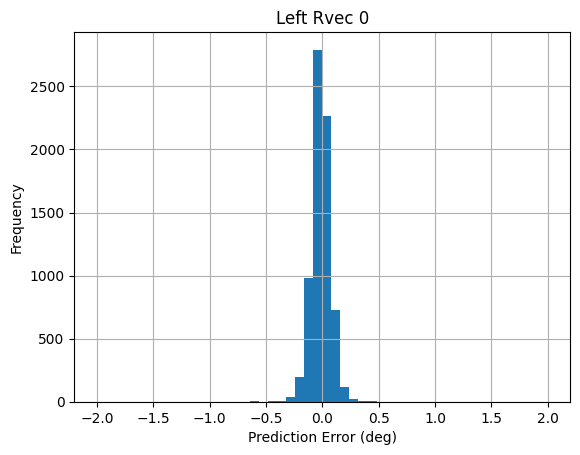

In [24]:
plt.hist(np.degrees(results[:,0]), bins=50, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 0')